In [3]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [4]:
df = pd.read_csv('../data/full_survey_data.csv')

/var/folders/b3/glj_22g92pl25nkdvjvxnzz00000gn/T/ipykernel_15746/4096187165.py:1: DtypeWarning: Columns (10,11,12,15,16,17,18,19,20,21,22,24,27,37,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,69,74,75,76,78,88,91,94,95,104,113,114,115,116,118,121,122,123,124,125,132,135,137,138,141,142,151,160,161,162,163,165,168,169,170,171,172,179,182,184,185,188,189,198,207,208,209,210,212,215,216,217,218,219,226,229,231,232,236,245,254,255,256,257,259,262,263,264,265,266,273,276,278,279,283,292,301,302,303,304,306,309,310,312,313,320,325,326,330,339,348,349,350,351,353,356,357,359,360,367,372,373,377,386,395,396,397,398,400,403,404,406,407,414,419,420,424,433,443,444,445,446,447,448,450,451,452,453,454,455,456,458,459,460,461,462,463,464,465,466,467,469,470,471,472,473,474,475,476,478,479,480,481,482,500,501,502,508,510,515,516,522,524,525,526,533,538,547,556,561,565,566,567,574,580,581,582,591,600,603,607,608,609,616,620,624,633,680,681,682,687,688,694,696,697,698,705,71

In [5]:
# Create a list for all crop_name and crop_residue_use columns
crop_cols = [f"crop_name_{i}" for i in range(1, 9)]
residue_cols = [f"crop_residue_use_{i}" for i in range(1, 9)]

In [6]:
# Create a list of tuples for each crop's pair of name and residue
records = []
for i in range(1, 9):
    temp_df = df[['id_unique', f'crop_name_{i}', f'crop_residue_use_{i}']].copy()
    temp_df.columns = ['id_unique', 'crop_name', 'crop_residue_use']
    temp_df['crop_number'] = i
    records.append(temp_df)

# Concatenate all together
long_df = pd.concat(records, ignore_index=True)

# Drop rows where crop_name is NaN
#long_df = long_df.dropna(subset=['crop_name'])

#sort
long_df = long_df.sort_values(['id_unique', 'crop_number']).reset_index(drop=True)

In [7]:
final_crop_df = long_df[(long_df.crop_name.notna()) & (long_df.crop_residue_use.notna())]
final_crop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95962 entries, 0 to 438976
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_unique         95962 non-null  object
 1   crop_name         95962 non-null  object
 2   crop_residue_use  95962 non-null  object
 3   crop_number       95962 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.7+ MB


In [8]:
final_crop_df['burn_crop'] = final_crop_df['crop_residue_use'].str.contains('burn', case=False, na=False).astype(int)


/var/folders/b3/glj_22g92pl25nkdvjvxnzz00000gn/T/ipykernel_15746/3975663582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_crop_df['burn_crop'] = final_crop_df['crop_residue_use'].str.contains('burn', case=False, na=False).astype(int)


In [9]:
# creating herd_size and renaming livestock head columns to be more succint
livestock_heads_cols = [
    'livestock_heads_sheep',
    'livestock_heads_cattle',
    'livestock_heads_pigs',
    'livestock_heads_goats',
    'livestock_heads_chicken',
    'livestock_heads_rabbits',
    'livestock_heads_otherpoultry',
    'livestock_heads_camel',
    'livestock_heads_guinea_pigs',
    'livestock_heads_oxen',
    'livestock_heads_buffalo',
    'livestock_heads_duck',
    'livestock_heads_geese',
    'livestock_heads_donkeys_horses',
    'livestock_heads_dogs',
    'livestock_heads_bees',
    'livestock_heads_fish'
]

# ok sum of heads to get herd_size
df['herd_size'] = df[livestock_heads_cols].sum(axis=1)

# Create a rename mapping
rename_dict = {
    col: col.replace('livestock_heads_', '') + '_heads'
    for col in df.columns if col.startswith('livestock_heads_')
}

# Apply the renaming
df = df.rename(columns=rename_dict)

In [10]:
livestock_cols = [f'livestock_died_{i}' for i in range(1, 6)]

In [11]:
# Step 1: Select relevant columns
name_cols = [f'livestock_name_{i}' for i in range(1, 6)]
died_cols = [f'livestock_died_{i}' for i in range(1, 6)]

# Step 2: Melt the livestock names and deaths
names_long = df.melt(id_vars='id_unique', value_vars=name_cols, 
                     var_name='animal_slot', value_name='livestock_name')

died_long = df.melt(id_vars='id_unique', value_vars=died_cols, 
                    var_name='animal_slot', value_name='livestock_died')

# Step 3: Make sure they align by extracting index number
names_long['slot'] = names_long['animal_slot'].str.extract(r'(\d+)').astype(int)
died_long['slot'] = died_long['animal_slot'].str.extract(r'(\d+)').astype(int)

# Step 4: Merge the two long DataFrames
long_df = pd.merge(
    names_long[['id_unique', 'slot', 'livestock_name']],
    died_long[['id_unique', 'slot', 'livestock_died']],
    on=['id_unique', 'slot']
)

# Optional: drop rows where animal name is missing
long_df = long_df.dropna(subset=['livestock_name']).reset_index(drop=True)

# Result: Each row is (id_unique, livestock_name, livestock_died)
print(long_df.head())


         id_unique  slot livestock_name  livestock_died
0  bf_adn_2019_1_1     1          sheep             0.0
1  bf_adn_2019_2_1     1         cattle             0.0
2  bf_adn_2019_3_1     1           pigs             3.0
3  bf_adn_2019_4_1     1         cattle             0.0
4  bf_adn_2019_5_1     1         cattle             0.0


In [12]:
long_df = long_df[long_df.livestock_died.notna()]

In [27]:
# Step 1: Get all renamed head columns (they should now end with '_heads')
head_cols = [col for col in df.columns if col.endswith('_heads')]

# Step 2: Melt to long format
long_heads_df = df.melt(
    id_vars='id_unique',
    value_vars=head_cols,
    var_name='livestock_name',
    value_name='livestock_heads'
)

# Step 3: Clean the livestock name (remove '_heads' suffix)
long_heads_df['livestock_name'] = long_heads_df['livestock_name'].str.replace('_heads', '', regex=False)

# Step 4: Drop rows where heads is missing or zero (optional)
long_heads_df = long_heads_df[long_heads_df['livestock_heads'].notna()]


# Final output
print(long_heads_df.head())

         id_unique livestock_name  livestock_heads
0  bf_adn_2019_1_1          sheep              3.0
1  bf_adn_2019_2_1          sheep              3.0
3  bf_adn_2019_4_1          sheep              4.0
4  bf_adn_2019_5_1          sheep              4.0
5  bf_adn_2019_6_1          sheep             15.0


In [33]:
# Merge heads and deaths
combined_df = pd.merge(
    long_heads_df,
    long_df[['id_unique', 'livestock_name', 'livestock_died']],
    on=['id_unique', 'livestock_name'],
    how='outer'
)

# Drop rows where either heads or died is missing
combined_df = combined_df.dropna(subset=['livestock_heads', 'livestock_died'])

In [25]:
combined_df

,id_unique,livestock_name,livestock_heads,livestock_died
0,bf_adn_2019_10_1,cattle,4.0,1.0
3,bf_adn_2019_10_1,sheep,5.0,2.0
4,bf_adn_2019_11_1,cattle,1.0,0.0
5,bf_adn_2019_11_1,chicken,4.0,4.0
6,bf_adn_2019_11_1,goats,1.0,0.0
...,...,...,...,...
153244,zm_scn_2017_98_1,cattle,6.0,0.0
153248,zm_scn_2017_98_1,goats,9.0,0.0
153254,zm_scn_2017_99_1,cattle,12.0,1.0
153266,zm_scn_2017_9_1,chicken,8.0,0.0


In [26]:
limit = 0.05 # setting the upper limit for winsorization, 5 percent
cols_to_winsorize = ['livestock_heads', 'livestock_died']
changed_counts = {}

for col in cols_to_winsorize:
    # Drop NaNs temporarily to avoid propagation issues
    original = combined_df[col].copy()
    non_nan = combined_df[col].dropna().values

    # Winsorize only upper end
    winsorized = winsorize(non_nan, limits=(0, limit))

    # Count how many values were capped
    changed = np.sum(non_nan != winsorized)
    changed_counts[col] = changed

    # Put values back into DataFrame (preserving original NaNs)
    combined_df.loc[ combined_df[col].notna(), col] = winsorized

# Show result
print("\nNumber of values Winsorized (upper end only):")
print(changed_counts)



Number of values Winsorized (upper end only):
{'livestock_heads': 2241, 'livestock_died': 2396}


In [19]:
print("Columns in df:", combined_df.columns.tolist())


Columns in df: ['id_unique', 'livestock_name', 'livestock_heads', 'livestock_died']


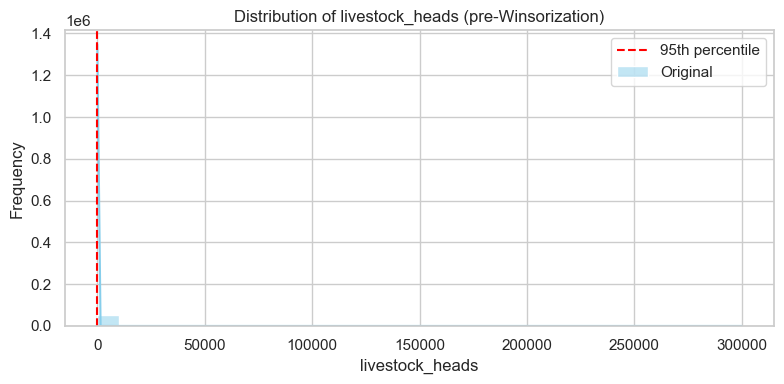

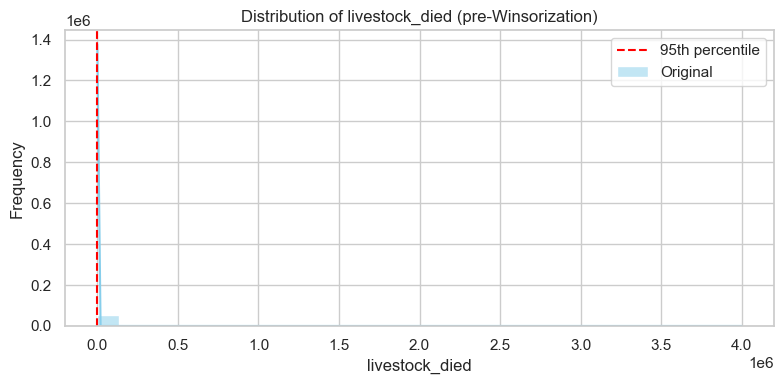

In [31]:
sns.set_theme(style="whitegrid")

# Winsorization settings
limit = 0.05
cols_to_winsorize = ['livestock_heads', 'livestock_died']
changed_counts = {}

for col in cols_to_winsorize:
    # Drop NaNs
    series = combined_df[col].dropna()

    # Compute upper threshold (e.g., 95th percentile)
    upper_cutoff = np.percentile(series, 100 * (1 - limit))
    outliers = series[series > upper_cutoff]

    # 🎨 Plot original values and highlight outliers
    plt.figure(figsize=(8, 4))
    sns.histplot(series, bins=30, kde=True, color='skyblue', label='Original')
    plt.axvline(upper_cutoff, color='red', linestyle='--', label=f'{100*(1-limit):.0f}th percentile')
    plt.title(f'Distribution of {col} (pre-Winsorization)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [32]:
outliers

96        20.0
141       15.0
292       15.0
302       20.0
2486      15.0
          ... 
151913    20.0
152163    15.0
152433    13.0
152523    15.0
152583    15.0
Name: livestock_died, Length: 2396, dtype: float64

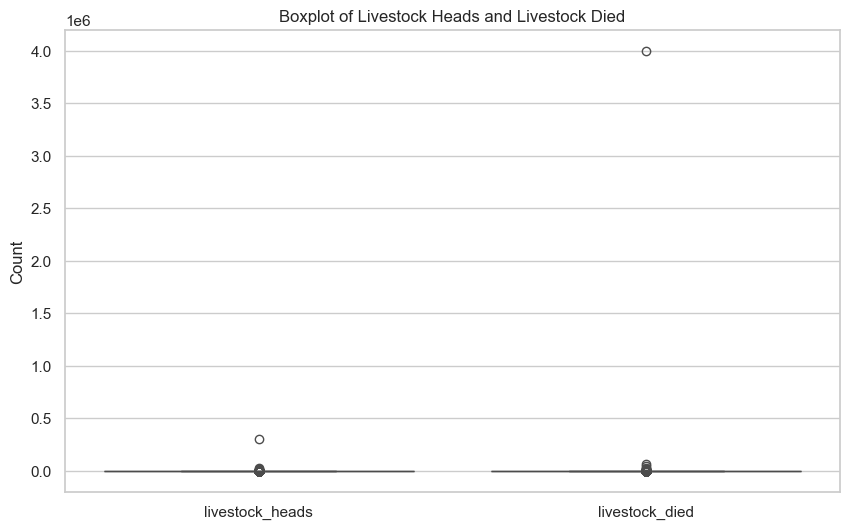

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df[['livestock_heads', 'livestock_died']])
plt.title('Boxplot of Livestock Heads and Livestock Died')
plt.ylabel('Count')
plt.show()

In [ ]:
combined_df[['livestock_heads', 'livestock_died']].describe()

,livestock_heads,livestock_died
count,51845.000000,5.184500e+04
mean,19.758144,8.367195e+01
std,1328.746405,1.757150e+04
min,0.000000,0.000000e+00
25%,2.000000,0.000000e+00
50%,4.000000,0.000000e+00
75%,10.000000,2.000000e+00
max,300000.000000,4.000000e+06


In [38]:
# Merge heads and deaths
combined_df = pd.merge(
    long_heads_df,
    long_df[['id_unique', 'livestock_name', 'livestock_died']],
    on=['id_unique', 'livestock_name'],
    how='outer'
)

# Drop rows where either heads or died is missing
combined_df = combined_df.dropna(subset=['livestock_heads', 'livestock_died'])

In [39]:
combined_df['died_to_heads'] = combined_df['livestock_died'] / combined_df['livestock_heads']


In [43]:
combined_df['heads_to_died'] = combined_df['livestock_heads'] / combined_df['livestock_died']

In [44]:
combined_df[combined_df.livestock_heads == 0]

,id_unique,livestock_name,livestock_heads,livestock_died,died_to_heads,heads_to_died
2708,bf_ec3_2022_167_2,donkeys_horses,0.0,0.0,NaN,NaN
3939,bf_ecd_2021_1043_1,chicken,0.0,3.0,inf,0.0
3986,bf_ecd_2021_106_1,cattle,0.0,0.0,NaN,NaN
4051,bf_ecd_2021_108_1,cattle,0.0,0.0,NaN,NaN
4067,bf_ecd_2021_1094_1,chicken,0.0,10.0,inf,0.0
...,...,...,...,...,...,...
141126,vn_crp_2020_583_1,buffalo,0.0,0.0,NaN,NaN
141133,vn_crp_2020_585_1,pigs,0.0,0.0,NaN,NaN
141138,vn_crp_2020_587_1,pigs,0.0,2.0,inf,0.0
141216,vn_crp_2020_618_1,pigs,0.0,0.0,NaN,NaN


In [68]:
df[df.id_unique == 'bf_ec3_2022_167_2'][[ 'donkeys_horses_heads']]

,donkeys_horses_heads
594,0.0


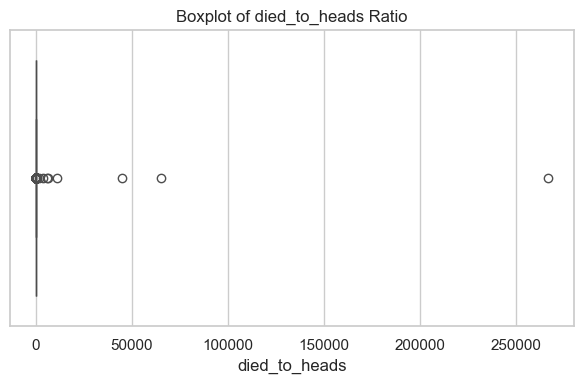

In [ ]:

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=combined_df['died_to_heads'].dropna(), color='orange')
    plt.title('Boxplot of died_to_heads Ratio')
    plt.xlabel('died_to_heads')
    plt.tight_layout()
    plt.show()


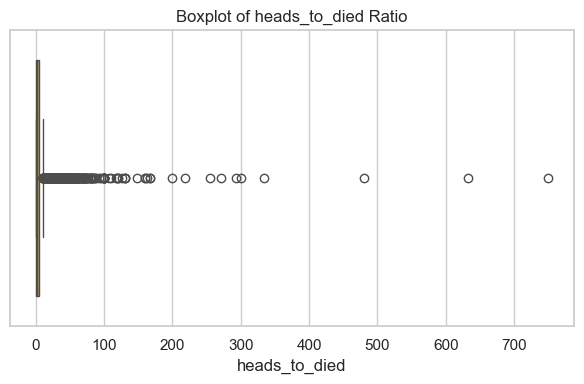

In [46]:
 plt.figure(figsize=(6, 4))
sns.boxplot(x=combined_df['heads_to_died'].dropna(), color='orange')
plt.title('Boxplot of heads_to_died Ratio')
plt.xlabel('heads_to_died')
plt.tight_layout()
plt.show()


In [48]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51845 entries, 0 to 153269
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_unique        51845 non-null  object 
 1   livestock_name   51845 non-null  object 
 2   livestock_heads  51845 non-null  float64
 3   livestock_died   51845 non-null  float64
 4   died_to_heads    50621 non-null  float64
 5   heads_to_died    50621 non-null  float64
dtypes: float64(4), object(2)
memory usage: 2.8+ MB


In [ ]:
print(f'{51845 - 50621} animal- unique ID pairs where both the animal head and deaths are zero') # nans 

1224 animal- unique ID pair where both the animal head and deaths are zero


In [51]:
combined_df = combined_df[combined_df.died_to_heads.notna()]
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50621 entries, 0 to 153269
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_unique        50621 non-null  object 
 1   livestock_name   50621 non-null  object 
 2   livestock_heads  50621 non-null  float64
 3   livestock_died   50621 non-null  float64
 4   died_to_heads    50621 non-null  float64
 5   heads_to_died    50621 non-null  float64
dtypes: float64(4), object(2)
memory usage: 2.7+ MB


In [52]:
combined_df[['heads_to_died', 'died_to_heads']].describe()

/Users/nishantshrestha/Library/Python/3.9/lib/python/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/nishantshrestha/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/nishantshrestha/Library/Python/3.9/lib/python/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,heads_to_died,died_to_heads
count,50621.0,50621.00
mean,inf,inf
std,NaN,NaN
min,0.0,0.00
25%,4.0,0.00
50%,NaN,0.00
75%,NaN,0.25
max,inf,inf


quite a few infs as we try to divide by zero.

In [59]:
combined_df[combined_df['died_to_heads'] == np.inf]

,id_unique,livestock_name,livestock_heads,livestock_died,died_to_heads,heads_to_died
3939,bf_ecd_2021_1043_1,chicken,0.0,3.0,inf,0.0
4067,bf_ecd_2021_1094_1,chicken,0.0,10.0,inf,0.0
6125,bf_ecd_2021_934_1,chicken,0.0,1.0,inf,0.0
6896,bf_pra_2021_1077_1,cattle,0.0,1.0,inf,0.0
7135,bf_pra_2021_1187_1,cattle,0.0,2.0,inf,0.0
...,...,...,...,...,...,...
140449,vn_crp_2020_347_1,cattle,0.0,1.0,inf,0.0
140678,vn_crp_2020_432_1,pigs,0.0,8.0,inf,0.0
140898,vn_crp_2020_501_1,chicken,0.0,30.0,inf,0.0
141138,vn_crp_2020_587_1,pigs,0.0,2.0,inf,0.0


In [56]:
#let's see how many infs we have in both heads_to_died and died_to_heads
combined_df[combined_df['heads_to_died'] == np.inf].shape[0] , combined_df[combined_df['died_to_heads'] == np.inf].shape[0]

(32527, 145)

In [69]:
death_to_heads_df = combined_df[combined_df['died_to_heads'] != np.inf].copy() # remove obs where there are deaths but no heads
death_to_heads_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50476 entries, 0 to 153269
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_unique        50476 non-null  object 
 1   livestock_name   50476 non-null  object 
 2   livestock_heads  50476 non-null  float64
 3   livestock_died   50476 non-null  float64
 4   died_to_heads    50476 non-null  float64
 5   heads_to_died    50476 non-null  float64
dtypes: float64(4), object(2)
memory usage: 2.7+ MB


In [70]:
death_to_heads_df['died_to_heads'].describe()

count     50476.000000
mean          8.379915
std        1239.724082
min           0.000000
25%           0.000000
50%           0.000000
75%           0.250000
max      266666.666667
Name: died_to_heads, dtype: float64

In [72]:

heads_to_died_df = combined_df[combined_df['heads_to_died'] != np.inf].copy() # remove obs where there are deaths but no heads
heads_to_died_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18094 entries, 0 to 153254
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_unique        18094 non-null  object 
 1   livestock_name   18094 non-null  object 
 2   livestock_heads  18094 non-null  float64
 3   livestock_died   18094 non-null  float64
 4   died_to_heads    18094 non-null  float64
 5   heads_to_died    18094 non-null  float64
dtypes: float64(4), object(2)
memory usage: 989.5+ KB


In [73]:
heads_to_died_df['heads_to_died'].describe()

count    18094.000000
mean         4.819115
std         12.737755
min          0.000000
25%          1.000000
50%          2.250000
75%          5.000000
max        750.000000
Name: heads_to_died, dtype: float64

Note: winsorizing won't take care of values where herd size is large, but 0 deaths


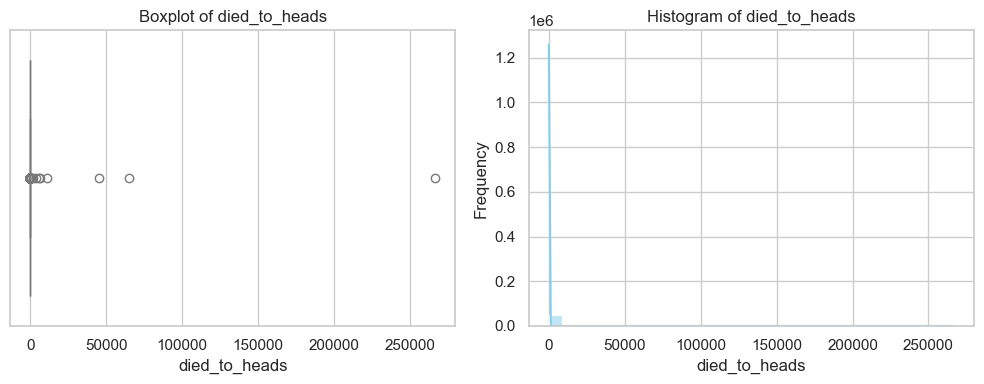

In [74]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=death_to_heads_df['died_to_heads'].dropna(), color='lightblue')
plt.title('Boxplot of died_to_heads')
plt.xlabel('died_to_heads')

plt.subplot(1, 2, 2)
sns.histplot(death_to_heads_df['died_to_heads'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Histogram of died_to_heads')
plt.xlabel('died_to_heads')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [84]:
death_to_heads_df[death_to_heads_df['died_to_heads'] != 0].info()


<class 'pandas.core.frame.DataFrame'>
Index: 17949 entries, 0 to 153254
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_unique        17949 non-null  object 
 1   livestock_name   17949 non-null  object 
 2   livestock_heads  17949 non-null  float64
 3   livestock_died   17949 non-null  float64
 4   died_to_heads    17949 non-null  float64
 5   heads_to_died    17949 non-null  float64
dtypes: float64(4), object(2)
memory usage: 981.6+ KB


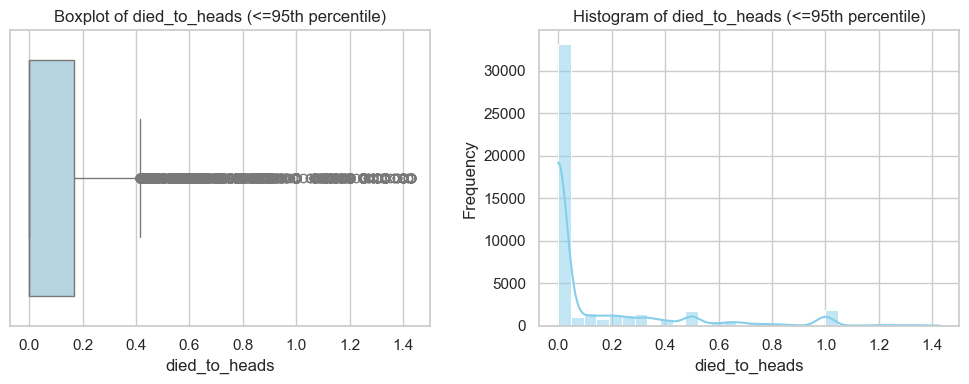

In [85]:
# Remove top 5th percentile for died_to_heads
cutoff = np.percentile(death_to_heads_df['died_to_heads'].dropna(), 95)
filtered_df = death_to_heads_df[death_to_heads_df['died_to_heads'] <= cutoff]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=filtered_df['died_to_heads'].dropna(), color='lightblue')
plt.title('Boxplot of died_to_heads (<=95th percentile)')
plt.xlabel('died_to_heads')

plt.subplot(1, 2, 2)
sns.histplot(filtered_df['died_to_heads'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Histogram of died_to_heads (<=95th percentile)')
plt.xlabel('died_to_heads')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [90]:
cutoff = np.percentile(death_to_heads_df['died_to_heads'].dropna(), 99.9)
cutoff

18.0

In [166]:
death_to_heads_df['died_to_heads'].describe()

count     50476.000000
mean          8.379915
std        1239.724082
min           0.000000
25%           0.000000
50%           0.000000
75%           0.250000
max      266666.666667
Name: died_to_heads, dtype: float64

In [91]:
no_zero_death_to_heads_df = death_to_heads_df[death_to_heads_df['died_to_heads'] != 0]
no_zero_death_to_heads_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17949 entries, 0 to 153254
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_unique        17949 non-null  object 
 1   livestock_name   17949 non-null  object 
 2   livestock_heads  17949 non-null  float64
 3   livestock_died   17949 non-null  float64
 4   died_to_heads    17949 non-null  float64
 5   heads_to_died    17949 non-null  float64
dtypes: float64(4), object(2)
memory usage: 981.6+ KB


In [120]:
no_zero_death_to_heads_df.died_to_heads.describe()

count     17949.000000
mean         23.565913
std        2078.917188
min           0.001333
25%           0.200000
50%           0.428571
75%           1.000000
max      266666.666667
Name: died_to_heads, dtype: float64

In [ ]:
cutoff = np.percentile(no_zero_death_to_heads_df['died_to_heads'].dropna(), 99)
cutoff

8.333333333333334

99.90 is 49, 99.80 is 20, and 99.95 is 187.5

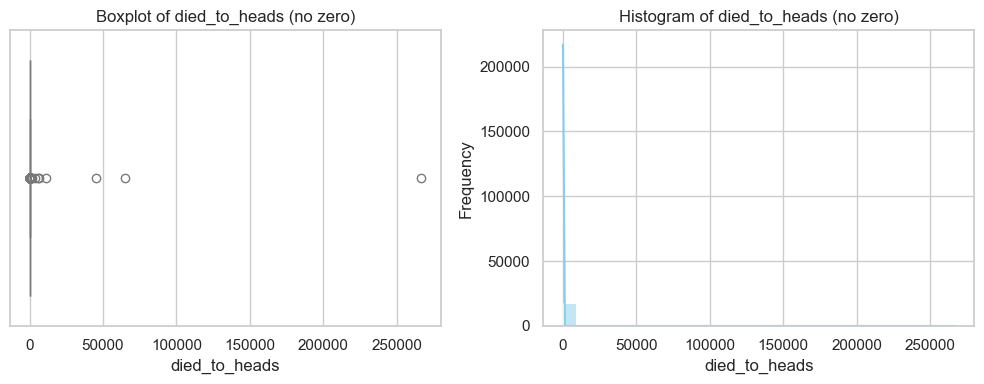

In [119]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=no_zero_death_to_heads_df['died_to_heads'].dropna(), color='lightblue')
plt.title('Boxplot of died_to_heads (no zero)')
plt.xlabel('died_to_heads')

plt.subplot(1, 2, 2)
sns.histplot(no_zero_death_to_heads_df['died_to_heads'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Histogram of died_to_heads (no zero)')
plt.xlabel('died_to_heads')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [149]:
# winsorize values above 99.90
values_to_winsorize = no_zero_death_to_heads_df['died_to_heads'].dropna().copy()
winsorized = winsorize(values_to_winsorize, limits=(0, 0.001))

# Count how many values were capped
changed = np.sum(values_to_winsorize != winsorized)

print('number of values changed:', changed)
print('total number of values:', values_to_winsorize.size)

number of values changed: 17
total number of values: 17949


In [150]:


# Drop NaNs and copy
values = no_zero_death_to_heads_df['died_to_heads'].dropna().copy()

# Winsorize (upper tail only)
winsorized_masked = winsorize(values, limits=(0, 0.001))

# Convert to plain NumPy array
winsorized_array = winsorized_masked.filled()  # remove mask

# Count how many values changed
changed = np.sum(values.values != winsorized_array)

print('number of values changed:', changed)
print('total number of values:', values.size)


number of values changed: 17
total number of values: 17949


In [151]:
winsorized.filled()


array([0.25      , 0.4       , 1.        , ..., 1.        , 0.2       ,
       0.08333333])

In [152]:
pd.Series(winsorized.filled()).describe()

count    17949.000000
mean         0.938242
std          2.351104
min          0.001333
25%          0.200000
50%          0.428571
75%          1.000000
max         49.000000
dtype: float64

count     17949.000000
mean         23.565913
std        2078.917188
min           0.001333
25%           0.200000
50%           0.428571
75%           1.000000
max      266666.666667
Name: died_to_heads, dtype: float64

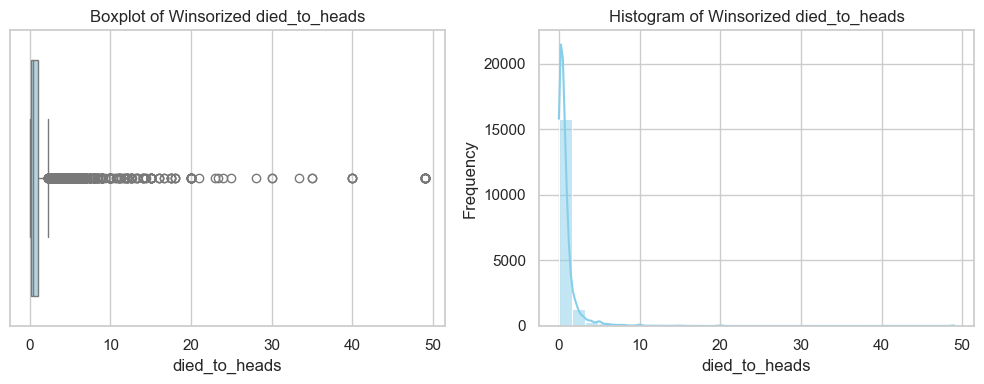

In [153]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=winsorized.filled(), color='lightblue')
plt.title('Boxplot of Winsorized died_to_heads')
plt.xlabel('died_to_heads')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(winsorized.filled(), bins=30, kde=True, color='skyblue')
plt.title('Histogram of Winsorized died_to_heads')
plt.xlabel('died_to_heads')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [155]:
pd.Series(winsorized.filled()).value_counts().sort_index(ascending=False).head(30)

49.000000    19
40.000000     4
35.000000     2
33.333333     1
30.000000     2
28.000000     1
25.000000     1
24.000000     1
23.333333     1
23.000000     1
21.000000     1
20.000000    16
18.000000     3
17.500000     4
16.666667     2
16.000000     3
15.000000    12
14.400000     1
14.333333     1
14.000000     4
13.333333     3
13.000000     1
12.666667     1
12.500000     5
12.000000     6
11.764706     1
11.666667     2
11.250000     2
11.000000     5
10.666667     2
Name: count, dtype: int64

In [145]:
pd.Series(winsorized_array).describe()

count    17949.000000
mean         0.842573
std          1.278781
min          0.001333
25%          0.200000
50%          0.428571
75%          1.000000
max          8.333333
dtype: float64

In [156]:
# now do for heards to died
no_zero_heads_to_death_df = heads_to_died_df[heads_to_died_df['heads_to_died'] != 0]
no_zero_heads_to_death_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17949 entries, 0 to 153254
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_unique        17949 non-null  object 
 1   livestock_name   17949 non-null  object 
 2   livestock_heads  17949 non-null  float64
 3   livestock_died   17949 non-null  float64
 4   died_to_heads    17949 non-null  float64
 5   heads_to_died    17949 non-null  float64
dtypes: float64(4), object(2)
memory usage: 981.6+ KB


In [201]:
cutoff = np.percentile(no_zero_heads_to_death_df['heads_to_died'].dropna(), 99.90)
cutoff

130.0

99 PERCENTILE IS 40, 98 IS 27, 99.5 IS 59.12, 99.8 IS 88.5 AND 99.92 IS 156,SO I CHOOSE 99.90

In [202]:
# winsorize values above 99.90
values_to_winsorize = no_zero_heads_to_death_df['heads_to_died'].dropna().copy()
winsorized = winsorize(values_to_winsorize, limits=(0, 0.001))

# Count how many values were capped
changed = np.sum(values_to_winsorize != winsorized)

print('number of values changed:', changed)
print('total number of values:', values_to_winsorize.size)

number of values changed: 17
total number of values: 17949


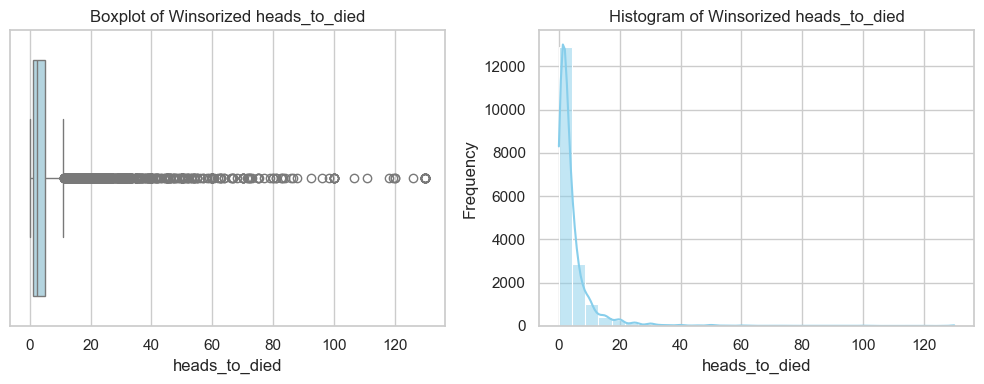

In [204]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=winsorized.filled(), color='lightblue')
plt.title('Boxplot of Winsorized heads_to_died')
plt.xlabel('heads_to_died')

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(winsorized.filled(), bins=30, kde=True, color='skyblue')
plt.title('Histogram of Winsorized heads_to_died')
plt.xlabel('heads_to_died')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [208]:
pd.Series(winsorized.filled()).describe()

count    17949.000000
mean         4.712031
std          8.720334
min          0.000004
25%          1.000000
50%          2.333333
75%          5.000000
max        130.000000
dtype: float64

In [209]:
combined_df

,id_unique,livestock_name,livestock_heads,livestock_died,died_to_heads,heads_to_died
0,bf_adn_2019_10_1,cattle,4.0,1.0,0.250000,4.0
3,bf_adn_2019_10_1,sheep,5.0,2.0,0.400000,2.5
4,bf_adn_2019_11_1,cattle,1.0,0.0,0.000000,inf
5,bf_adn_2019_11_1,chicken,4.0,4.0,1.000000,1.0
6,bf_adn_2019_11_1,goats,1.0,0.0,0.000000,inf
...,...,...,...,...,...,...
153244,zm_scn_2017_98_1,cattle,6.0,0.0,0.000000,inf
153248,zm_scn_2017_98_1,goats,9.0,0.0,0.000000,inf
153254,zm_scn_2017_99_1,cattle,12.0,1.0,0.083333,12.0
153266,zm_scn_2017_9_1,chicken,8.0,0.0,0.000000,inf


In [213]:
corrs = (
    combined_df.groupby("livestock_name")[["livestock_heads", "livestock_died"]]
    .corr()
    .iloc[0::2, -1]   # select heads–died correlation
)
print(corrs)


livestock_name                 
bees            livestock_heads   -3.601963e-18
buffalo         livestock_heads    3.761693e-02
camel           livestock_heads    4.291393e-01
cattle          livestock_heads    1.583969e-03
chicken         livestock_heads    2.145780e-01
dogs            livestock_heads             NaN
donkeys_horses  livestock_heads    1.509700e-02
duck            livestock_heads             NaN
fish            livestock_heads   -1.992677e-02
goats           livestock_heads    4.252619e-01
guinea_pigs     livestock_heads    1.557515e-01
otherpoultry    livestock_heads    1.984972e-01
oxen            livestock_heads             NaN
pigs            livestock_heads    6.252007e-01
rabbits         livestock_heads    3.169470e-01
sheep           livestock_heads   -3.949293e-03
Name: livestock_died, dtype: float64


In [214]:
# Filter first (strictly less than, as requested)
f = combined_df[
    (combined_df["livestock_heads"] < 130) &
    (combined_df["livestock_died"]  < 49)
]

# (Optional) drop rows with missing values in either column
f = f.dropna(subset=["livestock_heads", "livestock_died"])

# Compute Pearson correlations per animal
corrs = (
    f.groupby("livestock_name")[["livestock_heads", "livestock_died"]]
     .corr()
     .iloc[0::2, -1]  # heads–died correlation
)

print(corrs)


livestock_name                 
bees            livestock_heads   -3.601963e-18
buffalo         livestock_heads    3.761693e-02
camel           livestock_heads    4.291393e-01
cattle          livestock_heads    3.112873e-01
chicken         livestock_heads    2.214107e-01
dogs            livestock_heads             NaN
donkeys_horses  livestock_heads    3.625884e-02
duck            livestock_heads             NaN
fish            livestock_heads   -4.513363e-01
goats           livestock_heads    3.743987e-01
guinea_pigs     livestock_heads    1.557515e-01
otherpoultry    livestock_heads    1.830341e-01
oxen            livestock_heads             NaN
pigs            livestock_heads    1.583408e-01
rabbits         livestock_heads    3.169470e-01
sheep           livestock_heads    3.283817e-01
Name: livestock_died, dtype: float64


In [216]:
final_crop_df


,id_unique,crop_name,crop_residue_use,crop_number,burn_crop
0,bf_adn_2019_10_1,millet,soil feed,1,0
1,bf_adn_2019_10_1,groundnut,soil feed,2,0
2,bf_adn_2019_10_1,sesame,soil feed,3,0
8,bf_adn_2019_11_1,millet,feed soil,1,0
9,bf_adn_2019_11_1,maize,soil feed,2,0
...,...,...,...,...,...
438946,zm_scn_2017_96_1,sunflower,soil,3,0
438952,zm_scn_2017_97_1,maize,soil,1,0
438960,zm_scn_2017_98_1,maize,soil,1,0
438968,zm_scn_2017_99_1,maize,soil,1,0


In [221]:
final_crop_df.crop_residue_use.value_counts().sort_values(ascending=False).head(30)

crop_residue_use
feed                  29656
soil                  23677
soil feed              6092
feed compost           4020
burn                   3739
compost                2986
soil burn              1769
sell                   1501
feed soil              1391
fuel feed              1279
fuel                   1139
feed construction      1066
soil compost            994
soil fuel               982
burn feed               970
soil feed compost       922
feed sell               847
construction            696
no_answer               627
compost feed            614
construction feed       555
feed fuel               471
soil fuel feed          414
burn fuel               347
feed burn               322
soil construction       283
other feed compost      267
fuel feed compost       253
sell feed               229
soil burn feed          224
Name: count, dtype: int64

In [222]:
final_crop_df['feed_crop'] = final_crop_df['crop_residue_use'].str.contains('feed', case=False, na=False).astype(int)

In [223]:
final_crop_df

,id_unique,crop_name,crop_residue_use,crop_number,burn_crop,feed_crop
0,bf_adn_2019_10_1,millet,soil feed,1,0,1
1,bf_adn_2019_10_1,groundnut,soil feed,2,0,1
2,bf_adn_2019_10_1,sesame,soil feed,3,0,1
8,bf_adn_2019_11_1,millet,feed soil,1,0,1
9,bf_adn_2019_11_1,maize,soil feed,2,0,1
...,...,...,...,...,...,...
438946,zm_scn_2017_96_1,sunflower,soil,3,0,0
438952,zm_scn_2017_97_1,maize,soil,1,0,0
438960,zm_scn_2017_98_1,maize,soil,1,0,0
438968,zm_scn_2017_99_1,maize,soil,1,0,0


In [224]:
import numpy as np

def classify(row):
    if row["burn_crop"] == 1 and row["feed_crop"] == 0:
        return "Burned only"
    elif row["burn_crop"] == 0 and row["feed_crop"] == 1:
        return "Fed only"
    elif row["burn_crop"] == 1 and row["feed_crop"] == 1:
        return "Both"
    else:
        return "Neither"

final_crop_df["residue_use"] = final_crop_df.apply(classify, axis=1)


In [225]:
summary = final_crop_df.groupby(["crop_name", "residue_use"]).size().unstack(fill_value=0)
print(summary)



residue_use   Both  Burned only  Fed only  Neither
crop_name                                         
abish            0            0         1        0
achiote          0            0         0        1
agave            0            0         1        7
agushi           0            0         0        4
alfalfa          0            0        33       12
...            ...          ...       ...      ...
yams             0            0        13       56
yarlong_bean     0            0         0        1
ylang_ylang      0            0         0       22
yute             0            0         0        1
zucchini         3            6        30       26

[206 rows x 4 columns]


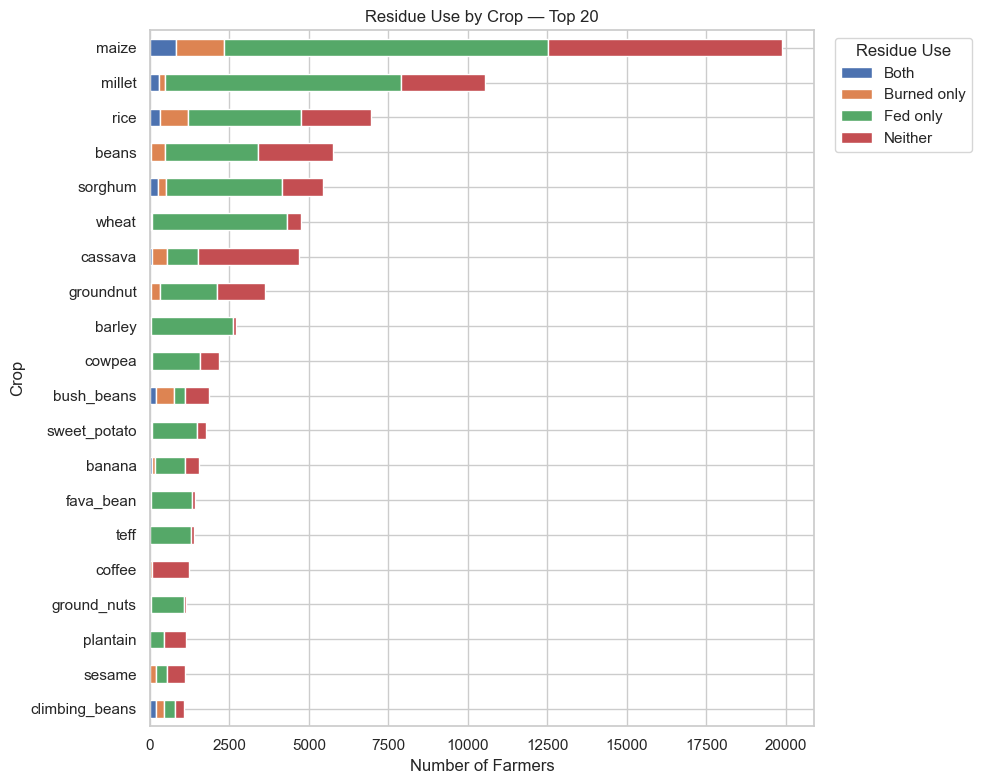

In [227]:


# 1) Keep only top 20 crops by total count across categories
top20 = (
    summary.assign(_total=summary.sum(axis=1))
           .sort_values("_total", ascending=False)
           .head(20)
           .drop(columns="_total")
)

# 2) Horizontal stacked bar; largest on top
ax = top20.plot(
    kind="barh",
    stacked=True,
    figsize=(10, 8)  # a bit taller for readability
    # no colormap if you have a style preference; otherwise you can add one
)

# Put largest at the top
ax.invert_yaxis()

plt.title("Residue Use by Crop — Top 20")
plt.xlabel("Number of Farmers")
plt.ylabel("Crop")
plt.legend(title="Residue Use", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()



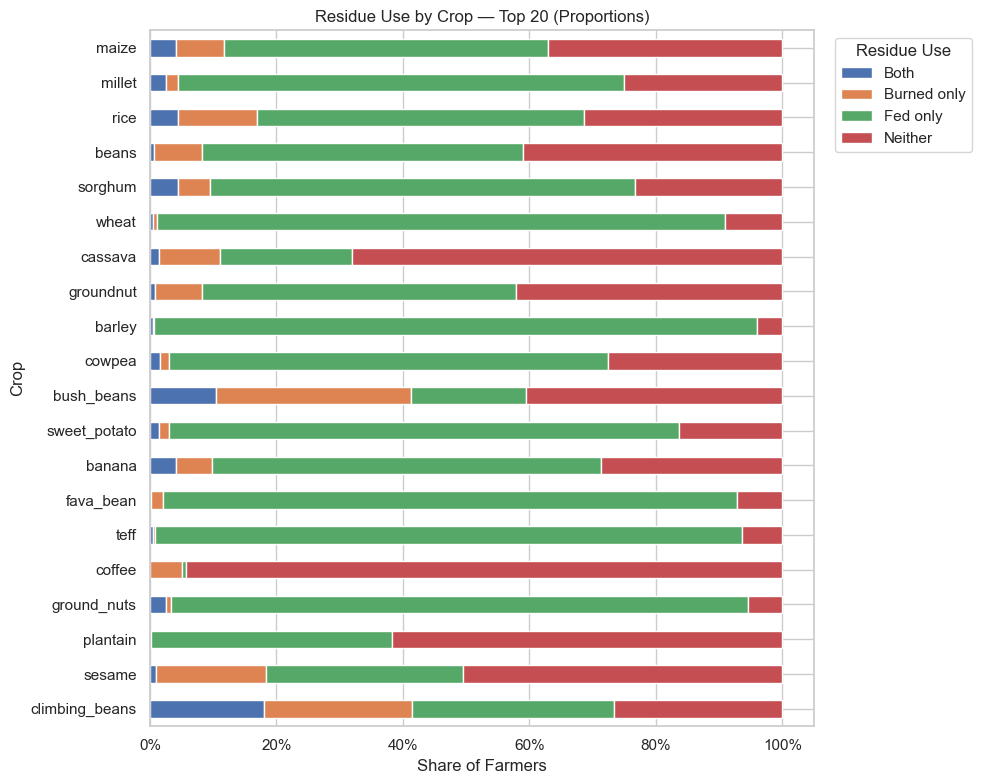

In [230]:
import matplotlib.ticker as mtick

# 1) Keep only top 20 crops by total count across categories
top20 = (
    summary.assign(_total=summary.sum(axis=1))
           .sort_values("_total", ascending=False)
           .head(20)
           .drop(columns="_total")
)

# 2) Convert to proportions (guard against divide-by-zero)
row_sums = top20.sum(axis=1)
top20_pct = top20.div(row_sums.replace(0, float("nan")), axis=0)

# 3) Horizontal stacked bar of proportions
ax = top20_pct.plot(kind="barh", stacked=True, figsize=(10, 8))

ax.invert_yaxis()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # 0–1 → 0–100%

plt.title("Residue Use by Crop — Top 20 (Proportions)")
plt.xlabel("Share of Farmers")
plt.ylabel("Crop")
plt.legend(title="Residue Use", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


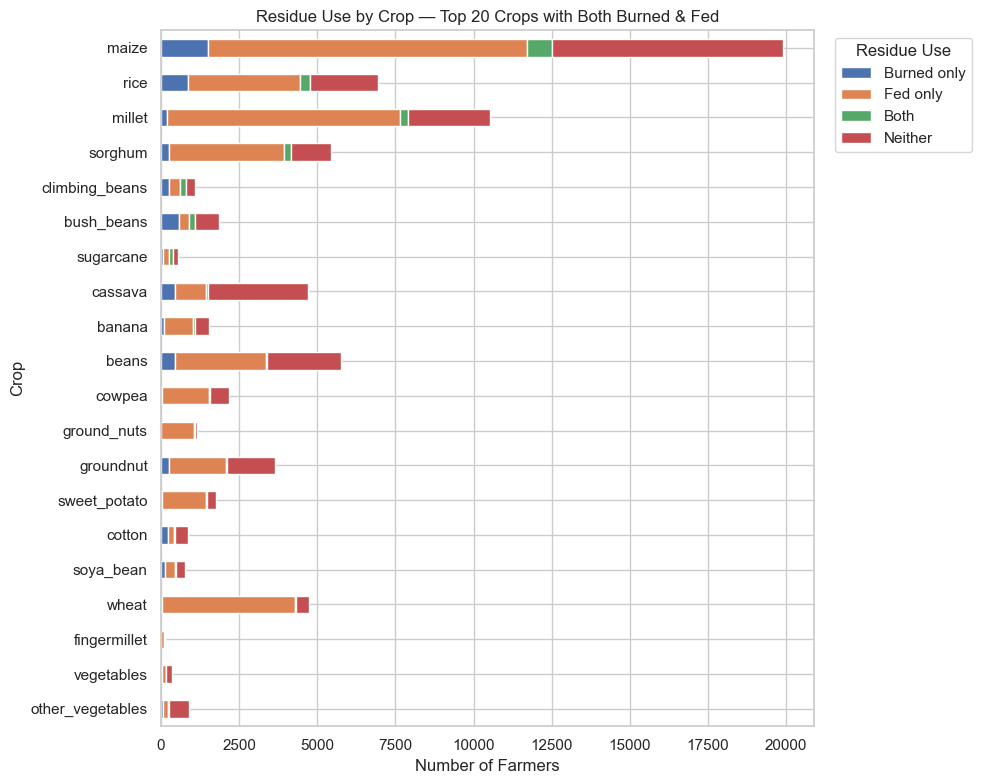

In [ ]:

# # 1) Top 20 crops by "Both"
# both_top20 = (
#     summary[summary.get("Both", 0) > 0]
#     .sort_values("Both", ascending=False)
#     .head(20)["Both"]
# )

# # 2) Subset summary to those crops and keep the same order
# sub = summary.loc[both_top20.index]

# # 3) (Optional) order columns consistently if these exist
# desired_order = ["Burned only", "Fed only", "Both", "Neither"]
# cols = [c for c in desired_order if c in sub.columns]
# if cols:
#     sub = sub[cols]

# # 4) Plot stacked horizontal bars
# ax = sub.plot(kind="barh", stacked=True, figsize=(10, 8))
# ax.invert_yaxis()  # largest "Both" at the top due to our row order

# plt.title("Residue Use by Crop — Top 20 Crops with Both Burned & Fed")
# plt.xlabel("Number of Farmers")
# plt.ylabel("Crop")
# plt.legend(title="Residue Use", bbox_to_anchor=(1.02, 1), loc="upper left")
# plt.tight_layout()
# plt.show()


In [235]:
final_crop_df

,id_unique,crop_name,crop_residue_use,crop_number,burn_crop,feed_crop,residue_use
0,bf_adn_2019_10_1,millet,soil feed,1,0,1,Fed only
1,bf_adn_2019_10_1,groundnut,soil feed,2,0,1,Fed only
2,bf_adn_2019_10_1,sesame,soil feed,3,0,1,Fed only
8,bf_adn_2019_11_1,millet,feed soil,1,0,1,Fed only
9,bf_adn_2019_11_1,maize,soil feed,2,0,1,Fed only
...,...,...,...,...,...,...,...
438946,zm_scn_2017_96_1,sunflower,soil,3,0,0,Neither
438952,zm_scn_2017_97_1,maize,soil,1,0,0,Neither
438960,zm_scn_2017_98_1,maize,soil,1,0,0,Neither
438968,zm_scn_2017_99_1,maize,soil,1,0,0,Neither


In [236]:
combined_df

,id_unique,livestock_name,livestock_heads,livestock_died,died_to_heads,heads_to_died
0,bf_adn_2019_10_1,cattle,4.0,1.0,0.250000,4.0
3,bf_adn_2019_10_1,sheep,5.0,2.0,0.400000,2.5
4,bf_adn_2019_11_1,cattle,1.0,0.0,0.000000,inf
5,bf_adn_2019_11_1,chicken,4.0,4.0,1.000000,1.0
6,bf_adn_2019_11_1,goats,1.0,0.0,0.000000,inf
...,...,...,...,...,...,...
153244,zm_scn_2017_98_1,cattle,6.0,0.0,0.000000,inf
153248,zm_scn_2017_98_1,goats,9.0,0.0,0.000000,inf
153254,zm_scn_2017_99_1,cattle,12.0,1.0,0.083333,12.0
153266,zm_scn_2017_9_1,chicken,8.0,0.0,0.000000,inf


In [237]:
# 1. Keep only crops where residues are used as feed
feed_crops = final_crop_df[final_crop_df['feed_crop'] == 1][['id_unique', 'crop_name', 'residue_use']]

# 2. Merge with livestock dataset on household ID
merged = pd.merge(feed_crops, combined_df, on="id_unique", how="inner")

In [240]:
merged

,id_unique,crop_name,residue_use,livestock_name,livestock_heads,livestock_died,died_to_heads,heads_to_died
0,bf_adn_2019_10_1,millet,Fed only,cattle,4.0,1.0,0.250000,4.000000
1,bf_adn_2019_10_1,millet,Fed only,sheep,5.0,2.0,0.400000,2.500000
2,bf_adn_2019_10_1,groundnut,Fed only,cattle,4.0,1.0,0.250000,4.000000
3,bf_adn_2019_10_1,groundnut,Fed only,sheep,5.0,2.0,0.400000,2.500000
4,bf_adn_2019_10_1,sesame,Fed only,cattle,4.0,1.0,0.250000,4.000000
...,...,...,...,...,...,...,...,...
75455,zm_scn_2017_51_1,maize,Fed only,cattle,4.0,1.0,0.250000,4.000000
75456,zm_scn_2017_608_1,maize,Fed only,cattle,7.0,3.0,0.428571,2.333333
75457,zm_scn_2017_608_1,maize,Fed only,goats,5.0,0.0,0.000000,inf
75458,zm_scn_2017_609_1,groundnut,Fed only,cattle,1.0,0.0,0.000000,inf


In [244]:
merged.residue_use.value_counts().sort_values(ascending=False)

residue_use
Fed only    71354
Both         4106
Name: count, dtype: int64

In [238]:
animals_residue = (
    merged.groupby("livestock_name")["id_unique"]
    .nunique()  # number of unique households
    .reset_index(name="num_households")
    .sort_values("num_households", ascending=False)
)

print(animals_residue)

    livestock_name  num_households
3           cattle           11918
4          chicken            7403
9            goats            5622
15           sheep            4841
6   donkeys_horses            2553
13            pigs            2069
11    otherpoultry             307
1          buffalo             290
14         rabbits             181
10     guinea_pigs              53
2            camel              32
8             fish              14
0             bees               6
5             dogs               4
7             duck               1
12            oxen               1


In [239]:
crop_animal = (
    merged.groupby(["crop_name", "livestock_name"])["id_unique"]
    .nunique()
    .reset_index(name="num_households")
    .sort_values("num_households", ascending=False)
)

print(crop_animal)

    crop_name  livestock_name  num_households
347     maize          cattle            5554
348     maize         chicken            3661
353     maize           goats            2964
612     wheat          cattle            2548
53     barley          cattle            1764
..        ...             ...             ...
397   oilpalm         rabbits               1
398   oilpalm           sheep               1
413     onion  donkeys_horses               1
417   oranges            pigs               1
631  zucchini           sheep               1

[632 rows x 3 columns]


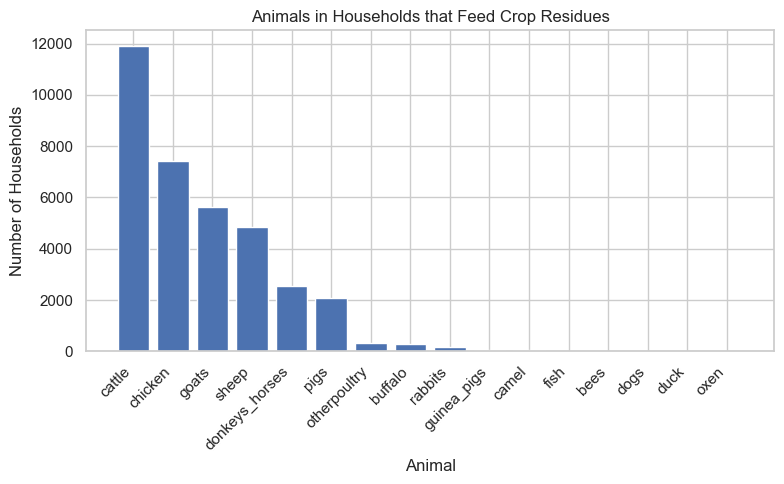

In [243]:
def plot_animals_residue(animals_residue):
    x = animals_residue['livestock_name'].astype(str).tolist()
    y = animals_residue['num_households'].tolist()

    plt.figure(figsize=(8, 5))
    plt.bar(x, y)
    plt.title("Animals in Households that Feed Crop Residues")
    plt.xlabel("Animal")
    plt.ylabel("Number of Households")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
plot_animals_residue(animals_residue)


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Household-level features 
# crops_df: needs columns ['id_unique', 'burn_crop'] where burn_crop ∈ {0,1}
hh_burn = (final_crop_df
           .groupby('id_unique', as_index=False)['burn_crop']
           .max()
           .rename(columns={'burn_crop':'any_burn'}))


hh_liv = (combined_df
          .groupby('id_unique', as_index=False)
          .agg(total_heads=('livestock_heads','sum'),
               total_died=('livestock_died','sum')))

#drop zero-heads to avoid inf
hh_liv['death_rate'] = hh_liv['total_died'] / hh_liv['total_heads']
hh_liv = hh_liv.replace([np.inf, -np.inf], np.nan).dropna(subset=['death_rate'])

hh = hh_liv.merge(hh_burn, on='id_unique', how='left').fillna({'any_burn':0})

#OLS
model = smf.ols('death_rate ~ any_burn + np.log1p(total_heads)', data=hh).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             death_rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                     1.846
Date:                Fri, 01 Aug 2025   Prob (F-statistic):              0.158
Time:                        10:57:14   Log-Likelihood:            -2.3411e+05
No. Observations:               28808   AIC:                         4.682e+05
Df Residuals:                   28805   BIC:                         4.683e+05
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.31

In [247]:
# Prepare animal-level death rate
animal = combined_df.copy()
animal['death_rate'] = animal['livestock_died'] / animal['livestock_heads']
animal = animal.replace([np.inf, -np.inf], np.nan).dropna(subset=['death_rate'])

# Attach household burning indicator
animal = animal.merge(hh_burn, on='id_unique', how='left').fillna({'any_burn':0})

# Optional controls: species fixed effects
# We'll add species dummies via patsy (C(livestock_name)).
m_animal = smf.ols('death_rate ~ any_burn + C(livestock_name)', data=animal).fit(cov_type='HC1')
print(m_animal.summary())


                            OLS Regression Results                            
Dep. Variable:             death_rate   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                     7.251
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           2.91e-16
Time:                        10:57:51   Log-Likelihood:            -4.3114e+05
No. Observations:               50476   AIC:                         8.623e+05
Df Residuals:                   50459   BIC:                         8.625e+05
Df Model:                          16                                         
Covariance Type:                  HC1                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

/Users/nishantshrestha/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 15
  warnings.warn('covariance of constraints does not have full '
